# Residual creation
In this notebook I will work on creating the residual portfolios based on the historical price dataset.

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
from numpy.linalg import eig, norm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import time

In [2]:
import os
filename = 'price_df.csv'
if os.path.exists(filename):
    price_df = pd.read_csv(filename)
    price_df = price_df.rename(columns={'Unnamed: 0':'date'})
    price_df.set_index('date', inplace=True)
    price_df.index = pd.to_datetime(price_df.index)

returns = price_df.pct_change(1,fill_method=None)

In [3]:
from tqdm import tqdm 
def pca(returns:pd.DataFrame, res_cov_window_size:int = 252, loadings_window_size:int=60, amount_of_factors:int=5):
    '''
    Function that computes the percentage returns of a residual portfolio constructed using pca
    Also with the weights needed to construct all these portfolio's
    
    Residual_output  is a T x N matrix 
    Residual_portfolio is a T x N x N matrix where e.g res_portf[t,i, :] gives you the vector 
    with all the weights you need to construct the residual portfolio i at timestep t
    Recovering phi from residual portfolio can be done by slicing as follows res_portf[t,:,:]
    '''
    T, N                = returns.shape
    returns             = returns.to_numpy()
    residuals_output    = np.zeros((T, N), dtype=float)    
    residual_portfolio  = np.zeros((T, N, N), dtype=float)
    for t in tqdm(range(res_cov_window_size+1,len(returns))):
        # only use the columns with no missing values
        idxsSelected = ~np.any(np.isnan(returns[(t - res_cov_window_size+1):t]), axis = 0).ravel()   
        if idxsSelected.sum() == 0:
            continue
        #calculate covariance
        res_cov_window = returns[(t - res_cov_window_size+1):t,idxsSelected]
        R_oos           = returns[((t+1) - res_cov_window_size+1):(t+1),idxsSelected] #TODO: adj for bias, original returns[(t - res_cov_window_size+1):(t+1),idxsSelected]
        res_mean = np.mean(res_cov_window,axis=0,keepdims=True)
        res_vol = np.sqrt(np.mean((res_cov_window-res_mean)**2,axis=0,keepdims=True))
        res_normalized = (res_cov_window - res_mean) / res_vol
        Corr = np.dot(res_normalized.T, res_normalized)
        eigenValues, eigenVectors = np.linalg.eigh(Corr)

        #calculate loadings
        w           = eigenVectors[:,-amount_of_factors:].real                      # w
        R           = res_cov_window[-loadings_window_size:,:]
        wtR         = res_cov_window[-loadings_window_size:,:] @ w                  # R * w 
        regr        = LinearRegression(fit_intercept=False, n_jobs=-1).fit(wtR,R)
        beta        = regr.coef_                                                    #beta
        phi         = (np.eye(beta.shape[0]) - beta @ w.T)
        #TODO: is ther somethign wrong with the returns they use here??
        residuals   = phi @ R_oos[-1,:].T
        residuals_output[t:(t+1),idxsSelected]                = residuals
        i = 0
        for idx, val in enumerate(idxsSelected):
            if val:  
                residual_portfolio[t:(t+1),idx,idxsSelected] = phi[i,:].reshape([1,-1])
                i += 1  
    return residuals_output, residual_portfolio

In [35]:
res_out, res_portf = pca(returns.loc[dt.datetime(2020,1,1):dt.datetime(2024,1,2)])

100%|██████████| 754/754 [00:29<00:00, 25.51it/s] 


In [36]:
residual_df = pd.DataFrame(res_out, index=returns.loc[dt.datetime(2020,1,1):dt.datetime(2024,1,2)].index, columns=returns.columns)

In [37]:
residual_df

,AMCR,KMX,LHX,NYT,MCD,ZBRA,EVHC,ENDP,CAG,MKC,...,Q,SWN,HSP,WFM,FTR,CMCSK,CAH,MSCI,WB,NCR
date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-12-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
residual_df.columns

Index(['AMCR', 'KMX', 'LHX', 'NYT', 'MCD', 'ZBRA', 'EVHC', 'ENDP', 'CAG',
       'MKC',
       ...
       'Q', 'SWN', 'HSP', 'WFM', 'FTR', 'CMCSK', 'CAH', 'MSCI', 'WB', 'NCR'],
      dtype='object', length=815)

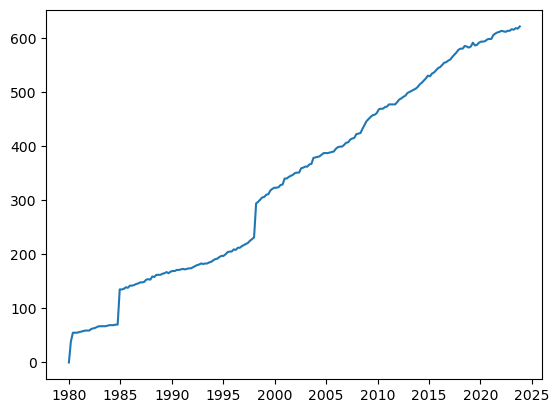

In [63]:
plt.plot(returns.iloc[::50].count(axis=1))

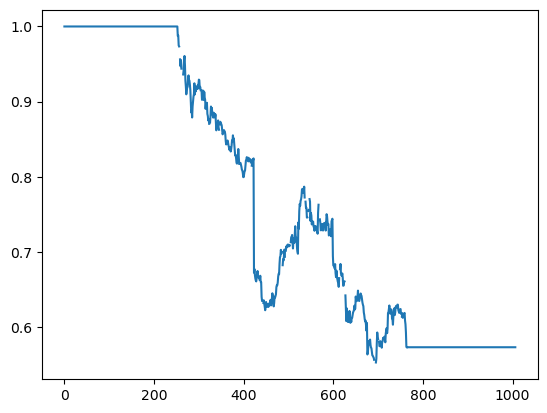

In [52]:
import matplotlib.pyplot as plt
plt.plot((residual_df.MKC + 1).cumprod().values)